# Interactive visualizer for 
*MOUSE WHOLE-BRAIN TRANSCRIPTOMIC CELL TYPE ATLAS*
*Hongkui Zeng, Allen Institute for Brain Science* 
<br> &  <br>
*MERFISH WHOLE MOUSE BRAIN*
*Xiaowei Zhuang, Harvard University*


<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/ca/c3/cac36e14-1858-4271-bfb2-1cbf0c75a848/abc-atlas-umap.png" width="400"/>


Test version of the online visualizer available [here](https://rdef654875678597657-5-ht-transcriptomics.hf.space/app). Download the precomputed [data](https://huggingface.co/spaces/RDeF654875678597657/5-HT-Transcriptomics/tree/main/Data) and point at the folder by changing the 'root_visualizer_data' in Utils.Settings. Afterwards run notebook from the 'RUN FROM HERE' cell. <br> All data needed by the visualizer is computed here by uncommenting code blocks. 

# Imports

In [1]:
%load_ext autoreload
%autoreload all
import os
    
os.chdir("..")
    

In [2]:
import pandas as pd
import anndata
import time
from tqdm.notebook import tqdm
from Utils.Settings import family_name,class_to_division, class_to_broad_division,neuron_cluster_groups_order, manifest, download_base, output_folder_calculations, output_folder, threshold_expression
from Utils.Utils import broad_division_color_map, cluster_groups_cmap, percentage_above_threshold_MER, percentage_above_threshold
from pathlib import Path
import numpy as np
from Utils.Utils import broad_division_color_map, genes_cmap_rgb, cluster_groups_cmap, genes_cmap, percentage_above_threshold

# Load trascriptomic data
*MOUSE WHOLE-BRAIN TRANSCRIPTOMIC CELL TYPE ATLAS*
*Hongkui Zeng, Allen Institute for Brain Science*

In [3]:
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [4]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [5]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [6]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath.replace('example_genes_all_cells_expression.csv', f'{family_name}_genes_all_cells_expression.csv'))
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


# Process

In [7]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

In [8]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


In [9]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


In [10]:
cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

In [11]:
selected_genes = exp.columns.sort_values()

joined = cell.join(exp)
joined_boolean =  cell.join( exp>threshold_expression)

subsampled = joined.loc[::30]

In [12]:
rnaseq_data = cell_with_membership.join(exp)

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

# Load data MERFISH data
*MERFISH WHOLE MOUSE BRAIN*
*Xiaowei Zhuang, Harvard University*

In [13]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

metadata = {}
for d in datasets :
    metadata[d] = manifest['file_listing'][d]['metadata']

In [14]:
cell = {}

for d in datasets :
    
    rpath = metadata[d]['cell_metadata']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    cell[d] = pd.read_csv(file, dtype={"cell_label":str})
    cell[d].set_index('cell_label',inplace=True)
    
    sdf = cell[d].groupby('brain_section_label')
    
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23
Zhuang-ABCA-4 : Number of cells =  162578 ,  Number of sections = 3


### Cluster annotation

Read in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level and the corresponding color.

In [15]:
taxonomy_metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_pivoted']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_details = pd.read_csv(file,keep_default_na=False)
cluster_details.set_index('cluster_alias', inplace=True)

rpath = taxonomy_metadata['cluster_to_cluster_annotation_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster_colors = pd.read_csv(file)
cluster_colors.set_index('cluster_alias', inplace=True)

In [16]:
cell_extended = {}

for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details,on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors,on='cluster_alias')

For convenience, we can cache this view for later reuse.

### Gene panel

All 4 datasets shares the same 1122 gene panel selected to enable faciliate the mapping to transcriptomically defined cell types taxonomies. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time.

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name.

In [17]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))


Number of genes =  1122


In [18]:
expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

In [19]:

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_MERFISH.csv"))
selected_genes = np.sort(gene_filtered["gene_symbol"].values)

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_RNAseq.csv"))
selected_genes_cl = np.sort(gene_filtered["gene_symbol"].values)

In [20]:
rpath = metadata[datasets[0]]['gene']['files']['csv']['relative_path'] # first dataset is big
file = os.path.join( download_base, rpath)
gene = pd.read_csv(file)
gene.set_index('gene_identifier',inplace=True)
print("Number of genes = ", len(gene))

expression_matrices = {}

for d in datasets :
    expression_matrices[d] = manifest['file_listing'][d]['expression_matrices']

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_MERFISH.csv")).set_index("gene_identifier")
selected_genes = np.sort(gene_filtered["gene_symbol"].values)
selected_genes 

Number of genes =  1122


array(['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2c', 'Htr3a',
       'Htr4', 'Htr7'], dtype=object)

In [21]:
merfish_data = {}
merfish_data_bool = {}

for d in tqdm(datasets):
    
    expression_matrices[d]
    rpath = expression_matrices[d][d]['log2']['files']['h5ad']['relative_path']
    file = os.path.join( download_base, rpath)
    
    adata = anndata.read_h5ad(file,backed='r')
    
    start = time.process_time()
    gdata = adata[:,gene_filtered.index].to_df()
    gdata.columns = gene_filtered.gene_symbol
    merfish_data[d] = cell_extended[d].join( gdata )
    merfish_data_bool[d] = cell_extended[d].join( gdata.astype("bool") )
    
    print(d,"-","time taken: ", time.process_time() - start)
    
    adata.file.close()
    del adata


  0%|          | 0/4 [00:00<?, ?it/s]

Zhuang-ABCA-1 - time taken:  68.32746069800001
Zhuang-ABCA-2 - time taken:  18.110775899999993
Zhuang-ABCA-3 - time taken:  24.39890512400001
Zhuang-ABCA-4 - time taken:  2.9661215849999962


### CCF registration and parcellation annotation

Each brain specimen has been registered to Allen CCFv3 atlas, resulting in an x, y, z coordinates and parcellation_index for each cell. 

In [22]:
ccf_coordinates = {}

for d in tqdm(datasets):
    
    rpath = manifest['file_listing'][d+'-CCF']['metadata']['ccf_coordinates']['files']['csv']['relative_path']
    file = os.path.join( download_base, rpath)
    ccf_coordinates[d] = pd.read_csv(file)
    ccf_coordinates[d].set_index('cell_label',inplace=True)
    ccf_coordinates[d].rename(columns={'x':'x_ccf','y':'y_ccf','z':'z_ccf'},inplace=True)
    
    merfish_data[d] = merfish_data[d].join(ccf_coordinates[d],how='inner')
    merfish_data_bool[d] = merfish_data_bool[d].join(ccf_coordinates[d],how='inner')

  0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
metadata = manifest['file_listing']['Allen-CCF-2020']['metadata']
rpath = metadata['parcellation_to_parcellation_term_membership_acronym']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_annotation = pd.read_csv(file)
parcellation_annotation.set_index('parcellation_index',inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]

rpath = metadata['parcellation_to_parcellation_term_membership_color']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
parcellation_color = pd.read_csv(file)
parcellation_color.set_index('parcellation_index',inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [24]:
for d in datasets :
    merfish_data[d] = merfish_data[d].join(parcellation_annotation,on='parcellation_index')
    merfish_data[d] = merfish_data[d].join(parcellation_color,on='parcellation_index')   
    merfish_data_bool[d] = merfish_data_bool[d].join(parcellation_annotation,on='parcellation_index')
    merfish_data_bool[d] = merfish_data_bool[d].join(parcellation_color,on='parcellation_index')   


In [25]:
total_bytes = merfish_data['Zhuang-ABCA-1'][['brain_section_label','parcellation_structure', 'parcellation_substructure','parcellation_division_color','parcellation_division' , "parcellation_structure_color", "Htr2a"]].memory_usage(index=True).sum()
size_in_mb = total_bytes / (1024 ** 2)
size_in_mb

149.70748901367188

In [26]:
sub_merfish_data = {}
for dataset in tqdm(merfish_data.keys()):
    data_merfish_cor =  merfish_data[dataset][["class", "subclass",'x', 'y', 'brain_section_label' , "parcellation_structure_color", 'Htr7', 'Htr1f',
       'Htr1d', 'Htr4', 'Htr1b', 'Htr2a', 'Htr1a', 'Htr2c', 'Htr3a', 'parcellation_division', 'parcellation_category','parcellation_structure', 'parcellation_substructure', 'parcellation_division_color', "cluster", 'neurotransmitter']].sort_values(by='brain_section_label').copy()
    sub_merfish_data[dataset]  = data_merfish_cor[data_merfish_cor['parcellation_division'] != "unassigned"]

  0%|          | 0/4 [00:00<?, ?it/s]

# RUN FROM HERE 


In [67]:
import pickle

In [68]:
%load_ext autoreload
%autoreload all
import os
    
os.chdir("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import panel as pn
import hvplot.pandas
import holoviews as hv
from holoviews import dim, opts
import param
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import pandas as pd
from pathlib import Path
import numpy as np
from Utils.Settings import root_visualizer_data, threshold_enriched_clusters, order_division, family_name,class_to_division, class_to_broad_division,neuron_cluster_groups_order, manifest, download_base, output_folder_calculations, output_folder
from Utils.Utils import broad_division_color_map, cluster_groups_cmap, percentage_above_threshold_MER, percentage_above_threshold

pn.extension(design="bootstrap", sizing_mode="stretch_width",throttled=True)

In [70]:
datasets = ['Zhuang-ABCA-1','Zhuang-ABCA-2','Zhuang-ABCA-3','Zhuang-ABCA-4']

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_MERFISH.csv"))
selected_genes = np.sort(gene_filtered["gene_symbol"].values)

gene_filtered  = pd.read_csv(Path(output_folder_calculations, "selected_genes_RNAseq.csv"))
selected_genes_cl = np.sort(gene_filtered["gene_symbol"].values)

In [71]:
# %%time
# with open(f'{root_visualizer_data}/sub_cell_expression.pickle', 'wb') as f:
#    pickle.dump(sub_merfish_data, f)

In [120]:
%%time
with open(f'{root_visualizer_data}/sub_cell_expression.pickle', "rb") as f:
    sub_merfish_data = pickle.load(f) 

CPU times: user 2.38 s, sys: 827 ms, total: 3.21 s
Wall time: 3.2 s


In [73]:
dataset = datasets[0]

In [74]:
class MERFISH_viz(param.Parameterized):

    dataset_selector = param.Selector(objects=datasets)
    brain_section_index = param.Integer(default=0, bounds=(0, sub_merfish_data[datasets[0]]["brain_section_label"].unique().shape[0]))
    gene_selector = param.ObjectSelector(default=selected_genes[0], objects=selected_genes.tolist())
    class_selector = param.ListSelector(default=sorted(sub_merfish_data[dataset]['class'].unique()), objects=sorted(sub_merfish_data[dataset]['class'].unique()))
    subclass_selector = param.ListSelector(default=sorted(sub_merfish_data[dataset]['subclass'].unique()), objects=sorted(sub_merfish_data[dataset]['subclass'].unique()))
    section_updated = param.Event()
    filtered_data_updated = param.Event()
    dataset_updated = param.Event()

    
    # Naming the keyword arguments `**params` is purely a convention.
    def __init__(self, sub_merfish_data, sel_dataset, sel_class, sel_subclass, brain_section_index, **params):
        super().__init__(**params)
        self.sub_merfish_data = sub_merfish_data
        self.current_data = self.sub_merfish_data[sel_dataset]
        self.filtered_data = self.current_data[self.current_data['class'].isin(sel_class) & self.current_data['subclass'].isin(sel_subclass)]

        brain_section = self.current_data['brain_section_label'].unique()[brain_section_index]
        section = self.filtered_data[self.filtered_data['brain_section_label'] == brain_section]

        self.section = section[section['parcellation_division'] != "unassigned"]

        self.control_panel = pn.Row(
            pn.Param(self.param['dataset_selector']),
            pn.Param(self.param['brain_section_index']),
            pn.Param(self.param['gene_selector']),
            pn.Param(self.param['class_selector']),
            pn.Param(self.param['subclass_selector'])
        )
                         
    @pn.depends("filtered_data_updated", "gene_selector", "brain_section_index")
    def plot_expr_across_slices(self):

        curve_data = self.filtered_data[self.filtered_data[self.gene_selector] > 0].groupby('brain_section_label')[self.gene_selector].mean()
        curve_data.rename(f"Expression {self.gene_selector}", inplace=True)
        curve = hv.Curve(curve_data, label=f'Log(CPM) {self.gene_selector}').opts(xaxis=None,  height=140, responsive=True, active_tools=[])
    
        grouped_data = self.filtered_data.groupby('brain_section_label')[self.gene_selector].apply(
            percentage_above_threshold_MER).reset_index()
        grouped_data.rename(columns={self.gene_selector: f"% expressing {self.gene_selector}"}, inplace=True)
        percentage_curve = hv.Curve(grouped_data, 'brain_section_label', f"% expressing {self.gene_selector}", label=f'Percentage expressing {self.gene_selector}').opts(xaxis=None,
                                                                                                       height=140,
                                                                                                       responsive=True,
                                                                                                       active_tools=[])
    
        vline = hv.VLine(self.brain_section_index).opts(line_color='red', line_width=2)
        percentage_of_all_cells = ((self.filtered_data.groupby('brain_section_label').size()/self.current_data.groupby('brain_section_label').size())*100).fillna(0)
        percentage_of_all_cells.name = "% of all cells"
        ratio_cells = hv.Curve( percentage_of_all_cells, 'brain_section_label', "% of all cells",  label='Percentage of all cells').opts(xaxis=None,
                                                                                                       height=100,
                                                                                                       responsive=True,
                                                                                                       active_tools=[])
          
        return hv.Layout([(ratio_cells * vline), (curve * vline), (percentage_curve * vline)]).cols(1)

    
    @pn.depends("section_updated", "gene_selector")
    def plot_bar(self):


        color_map = self.section.groupby('parcellation_structure')['parcellation_structure_color'].first().to_dict()
    
        hv_ds = hv.Dataset(self.section.groupby(['parcellation_structure'])[self.gene_selector].apply(percentage_above_threshold_MER).sort_values(ascending=False).head(20).reset_index(), 
                           kdims=['parcellation_structure'], vdims=[self.gene_selector])
        
        # Create the vertical Bar chart with rotated xticklabels
        bar_plot = hv.Bars(hv_ds).opts(
            color=dim('parcellation_structure').categorize(color_map, 'gray'),
            active_tools=[],
            tools=["hover"],
            responsive=True,
            frame_height=100,
            invert_axes=False,
            xrotation=90  # Rotate xticklabels by 90 degrees
        )
        
        grouped_data = self.section.groupby(['parcellation_structure'])[self.gene_selector].apply(percentage_above_threshold_MER).sort_values(
        ascending=False).head(30).reset_index()
        counts = self.section['parcellation_structure'].value_counts().reindex(grouped_data['parcellation_structure']).fillna(0)

        labels = hv.Labels({'x': grouped_data['parcellation_structure'], 'y': grouped_data[self.gene_selector], 'text': counts},
                       ['x', 'y'], 'text').opts(text_font_size='8pt', text_color="black", yoffset=-5)
 
        return bar_plot * labels

    
    @pn.depends("section_updated", "gene_selector")
    def plot_section(self):
        plot1 = hv.Points(data=self.section, kdims=['x', 'y' ], vdims=[self.gene_selector,'parcellation_structure', 'parcellation_substructure']).opts(width=550,colorbar=True, cmap='rocket_r', size=2, color=self.gene_selector)
        plot2 = hv.NdOverlay({division: hv.Points(self.section[self.section['parcellation_division'] == division], ['x', 'y'], ['parcellation_division_color','parcellation_structure', 'parcellation_substructure']).opts(color='parcellation_division_color', size=2) for division in self.section[self.section['parcellation_category'] == "grey"]['parcellation_division'].unique()}, kdims='parcellation_division').opts(legend_position='right', width=650,show_legend=True, xlim=(0,6), ylim=(0,6))
    
        common_opts = opts.Points(height=500,  invert_yaxis=True, xaxis=None, yaxis=None,show_grid=False, active_tools=[], tools=["hover"])
      
        return (plot1 + plot2).opts(common_opts)

    @pn.depends("brain_section_index","filtered_data_updated",  watch=True)
    def get_section(self):
        brain_section = self.current_data['brain_section_label'].unique()[self.brain_section_index]
        section = self.filtered_data[self.filtered_data['brain_section_label'] == brain_section]
        self.section = section[section['parcellation_division'] != "unassigned"]

        self.section_updated = True


    @pn.depends("dataset_selector", watch=True)
    def update_current_data(self):
        self.current_data = self.sub_merfish_data[self.dataset_selector]
        self.brain_section_index = 0
        self.param.brain_section_index.bounds=(0, self.current_data["brain_section_label"].unique().shape[0]) 
        self.dataset_updated = True

    @pn.depends("class_selector", "subclass_selector", "dataset_updated", watch=True)
    def filter_by_class_subclass(self):
        self.filtered_data = self.current_data[self.current_data['class'].isin(self.class_selector) & self.current_data['subclass'].isin(self.subclass_selector)]
        self.filtered_data_updated = True
        
        
    @pn.depends("class_selector", watch=True)        
    def update_subclasses(self):
        self.param.subclass_selector.objects = sorted(self.current_data[self.current_data['class'].isin(self.class_selector)]['subclass'].unique())
        self.subclass_selector = sorted(self.current_data[(self.current_data['class'].isin(self.class_selector))]['subclass'].unique())
        
viz = MERFISH_viz(sub_merfish_data, datasets[0], sub_merfish_data[datasets[0]]["class"].unique(),  sub_merfish_data[dataset]["subclass"].unique(), 0)


In [75]:


# Title of the paper and authors
# Custom HTML for the title
custom_title_html = """
            <div style="text-align: center; max-width: 1200px; margin: 20px auto;">
            <h1 style="font-weight: 900; font-size: 3rem; margin: 0rem">
                  Transcriptomic Mapping of the 5-HT Receptor Landscape
            </h1>
            <h2 style="font-weight: 450; font-size: 1rem; margin: 0rem">
            Roberto De Filippo<sup>#</sup>, Dietmar Schmitz
            </h2>
            <h2 style="font-weight: 450; font-size: 1rem; margin: 0rem">
            <sup>#</sup>Corresponding author
            </h2>
            <h2 style="font-weight: 450; font-size: 1rem; margin: 0rem">
            [<a href="https://github.com/RobertoDF/5-HT2A-MERFISH" style="color:blue;">Article</a>]
            [<a href="https://github.com/RobertoDF/5-HT2A-MERFISH" style="color:blue;">Github</a>]
            </h2>
            <h2 style="font-weight: 450; font-size: 1rem;">
            Custom visualizer for MERFISH dataset provided by [<a href="https://www.nature.com/articles/s41586-023-06808-9" style="color:blue;">Zhang et al., 2023</a>] </h2>
            <h2 style="font-weight: 450; font-size: 1rem;">
            By <b>Roberto De Filippo</b>
            </h2>
            </div>
            """

# Create a Panel HTML pane with the custom title
custom_title_pane = pn.pane.HTML(custom_title_html, sizing_mode='stretch_width')

In [76]:
dashboard_spatial = pn.Column(custom_title_pane, viz.control_panel, viz.plot_expr_across_slices, viz.plot_bar, viz.plot_section)

In [77]:
dashboard_spatial

Column(design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')
    [0] HTML(str, design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')
    [1] Row(design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')
        [0] Param(MERFISH_viz, design=<class 'panel.theme.bootst..., parameters=['dataset_selector'], show_name=False, sizing_mode='stretch_width')
        [1] Param(MERFISH_viz, design=<class 'panel.theme.bootst..., parameters=['brain_section_index'], show_name=False, sizing_mode='stretch_width')
        [2] Param(MERFISH_viz, design=<class 'panel.theme.bootst..., parameters=['gene_selector'], show_name=False, sizing_mode='stretch_width')
        [3] Param(MERFISH_viz, design=<class 'panel.theme.bootst..., parameters=['class_selector'], show_name=False, sizing_mode='stretch_width')
        [4] Param(MERFISH_viz, design=<class 'panel.theme.bootst..., parameters=['subclass_selector'], show_name=False, sizing_mode='stretch_width')
    [2] ParamMethod(method, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')
    [3] ParamMethod(method, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')
    [4] ParamMethod(method, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.bootst..., sizing_mode='stretch_width')

In [78]:
def plot_class_expression_split_by_categories(subfig,  cls, df_subset, gene):
    axs = subfig.subplots(4,1)
    subfig.subplots_adjust(left=0.05, right=.95)
    
    
    sns.violinplot(data=df_subset, y=f'{gene} prevalence (%)', x='subclass', hue='subclass' ,ax=axs[0], palette= classification_cmap, fill=False)
        
    # Set the title with desired modifications
    title = axs[0].set_title(cls, color=classification_cmap[cls], fontweight='bold', fontsize=20)
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
    subfig.set_facecolor(mcolors.to_rgba(classification_cmap[cls], alpha=0.15) )
    
    axs[0].set_ylim(0, 100)  # Set y-axis limit to 1
    axs[0].xaxis.set_ticks_position('top') 
    axs[0].tick_params(axis='x', length=0)
    
    sns.violinplot(data=df_subset, y=f'{gene} prevalence (%)', x='supertype', hue='supertype' ,ax=axs[1], palette= classification_cmap, fill=False)
    axs[1].set_title(cls)
    axs[1].set_ylim(0, 100)  # Set y-axis limit to 1
    
    
    sns.barplot(data=df_subset, y=f'{gene} prevalence (%)', x='cluster',hue='cluster' ,ax=axs[2], palette= classification_cmap)
    axs[2].set_title(cls)
    axs[2].set_ylim(0, 100)  # Set y-axis limit to 1
    
    axs[2].set( ylabel='')
    axs[0].set( ylabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[1].set(xticks=[], xlabel='')
    axs[0].set(xticks=[], xlabel='')
    axs[0].set( xlabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[1].set_title('')
    axs[2].set_title('')
    plt.draw()
    for tick in axs[0].get_xticklabels():
        tick.set_color(classification_cmap[tick.get_text()])
    
    # Identify positions for subclass delimiters in the cluster graph
    subclass_ends = df_subset.groupby('subclass').size().cumsum()
    subclass_positions = subclass_ends - 1
    
    # For the third plot (clusters):
    for pos in subclass_positions[:-1]:
        axs[2].axvline(pos + 0.5, color='gray', linestyle='--')
    
    # For the first plot (subclass), simply draw lines between unique subclasses
    for i in range(1, len(df_subset['subclass'].unique())):
        axs[0].axvline(i - 0.5, color='gray', linestyle='--')
    
    # For the second plot (supertype), the position will be based on unique supertypes per subclass
    supertype_ends = df_subset.groupby('subclass')['supertype'].nunique().cumsum()
    supertype_positions = supertype_ends - 1
    for pos in supertype_positions[:-1]:
        axs[1].axvline(pos + 0.5, color='gray', linestyle='--')
    
    
    # For the first plot (subclass):
    subclasses = df_subset['subclass'].unique()
    start = -.5
    for i, subclass in enumerate(subclasses):
        end = i + 0.5
        color = classification_cmap[subclass]
        axs[0].axvspan(start+.05, end-.05, facecolor=color, alpha=0.15)
        start = end
    
    
    # For the second plot (supertype), determine filling areas based on unique supertypes per subclass
    supertype_ends = df_subset.groupby('subclass')['supertype'].nunique().cumsum()
    supertype_positions = supertype_ends - 1
    
    previous_position = -0.5  # initialize to start from the first entry
    for idx, pos in enumerate(supertype_positions):
        current_position = pos + 0.5
        # Retrieve the subclass name for the current supertype
        subclass_name = df_subset['subclass'].unique()[idx]
        color = classification_cmap[subclass_name]
        
        axs[1].axvspan(previous_position + 0.2, current_position -.2, facecolor=color, alpha=0.15)
    
        previous_position = current_position  # set for the next iteration
    
    ####third plot filling
    # Get a mapping of subclasses to their dominant cluster
    subclass_to_cluster = df_subset.groupby('subclass')['cluster'].apply(lambda x: x.value_counts().idxmax())
    
    # Define previous position to help us fill areas between borders
    prev_pos = 0
    
    # Iterate over the subclass positions and the corresponding subclasses
    for idx, (subclass, cluster) in enumerate(subclass_to_cluster.items()):
        # Get the color for this subclass's dominant cluster from your cmap
        color_value = classification_cmap[cluster]
        
        # End position is either the next border position or the end of the plot
        end_pos = subclass_positions.iloc[idx] if idx < len(subclass_positions) else len(df_subset['cluster']) - 1
        
        # Fill the area with the given color
        axs[2].fill_between([prev_pos, end_pos], 0, 100, color=color_value, alpha=0.15)
        
        # Update the previous position to the current position
        prev_pos = end_pos + 1
    
    # Adjust the xlim of each axis
    axs[0].set_xlim(-0.5, len(df_subset['subclass'].unique()) - 0.5)
    axs[1].set_xlim(-0.5, len(df_subset['supertype'].unique()) - 0.5)
    axs[2].set_xlim(-.8, len(df_subset['cluster'].unique()))

    # Now, add legend in the fourth axis:
    patches = [plt.Line2D([0], [0], color=classification_cmap[c], lw=8) for c in df_subset["subclass"].unique()]
    labels = list(df_subset["subclass"].unique())
    
    axs[3].legend(patches, labels, loc='center', ncol=6, handlelength=1.8, handleheight=1)
    axs[3].axis('off')  # Hide axis

    sns.despine(bottom=True)  



In [79]:
group_selector = pn.widgets.Select(name='Group', options=neuron_cluster_groups_order, value=neuron_cluster_groups_order[0])
gene_selector = pn.widgets.Select(name='Gene', options=list(selected_genes_cl), value=selected_genes_cl[0])


In [80]:
#rnaseq_data_sub = rnaseq_data[ list(selected_genes_cl) + ["cluster_group_name","class","subclass", "supertype", "cluster"]]

In [81]:
##%%time
#rnaseq_data_sub.to_csv(f"{root_visualizer_data}/joined_with_membership_sub.csv")

In [82]:
%%time
# test file
rnaseq_data_sub = pd.read_csv(f"{root_visualizer_data}/joined_with_membership_sub.csv")

CPU times: user 21.9 s, sys: 4.54 s, total: 26.4 s
Wall time: 26.4 s


In [83]:
@pn.depends(group_selector, gene_selector)
def interactive_plot(group, gene):
    global global_saved_fig, group_g, gene_g
    data = rnaseq_data_sub[rnaseq_data_sub["cluster_group_name"]==group]
    data = data.groupby(["cluster_group_name","class","subclass", "supertype", "cluster"])[gene].apply(percentage_above_threshold).reset_index()
    data = data[data["cluster_group_name"]!="WholeBrain"]
    data["cluster_group_name"] = pd.Categorical(data["cluster_group_name"], categories=neuron_cluster_groups_order, ordered=True)
    data = data.sort_values(by=["cluster_group_name", "class"])

    data.rename(columns={gene: f'{gene} prevalence (%)'}, inplace=True)

    fig = plt.figure(figsize=(25, 5*data['class'].nunique()))
    gs = gridspec.GridSpec(data['class'].nunique(), 1)

    for n, cls in tqdm(enumerate(data['class'].unique())):
        df_subset = data[data['class'] == cls]
        subfig = fig.add_subfigure(gs[n,:])   
        subfig.subplots_adjust(left=0.05, right=.95, bottom=0.01)
        plot_class_expression_split_by_categories(subfig, cls, df_subset, gene)


    global_saved_fig = fig
    group_g = group
    gene_g = gene
    
    fig.suptitle(group, y=1.04, fontweight='bold', fontsize=20);
    print(group, gene)

    return fig

In [84]:
def save_fig():
    if global_saved_fig:
        global_saved_fig.savefig(Path(output_folder, f"{group_g}-{gene_g}.png"))
        print(f"Saved")
    else:
        print("No figure to save")

save_button = pn.widgets.Button(name="Save Figure", button_type='primary')
save_button.on_click(save_fig)

Watcher(inst=Button(button_type='primary', design=<class 'panel.theme.bootst..., name='Save Figure', sizing_mode='stretch_width'), cls=<class 'panel.widgets.button.Button'>, fn=<function save_fig at 0x7fb6c91c60c0>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

In [85]:
#joined_sub = joined[ list(selected_genes_cl) + ["class","subclass", "supertype", "cluster", "subclass_color", 'class_color', "brain_section_label", 'parcellation_division', 
# #                                              'parcellation_structure', 'parcellation_substructure', 'parcellation_division_color', 'parcellation_category']]


#joined_sub.to_csv("/alzheimer/Roberto/Github/Transcriptomics-5-HT-huggingface/Data/joined_sub.csv")


joined_sub = pd.read_csv(f"{root_visualizer_data}/joined_sub.csv")

classification_cmap = joined_sub.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined_sub.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined_sub.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined_sub.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


0it [00:00, ?it/s]

Pallium-Glut Htr1a


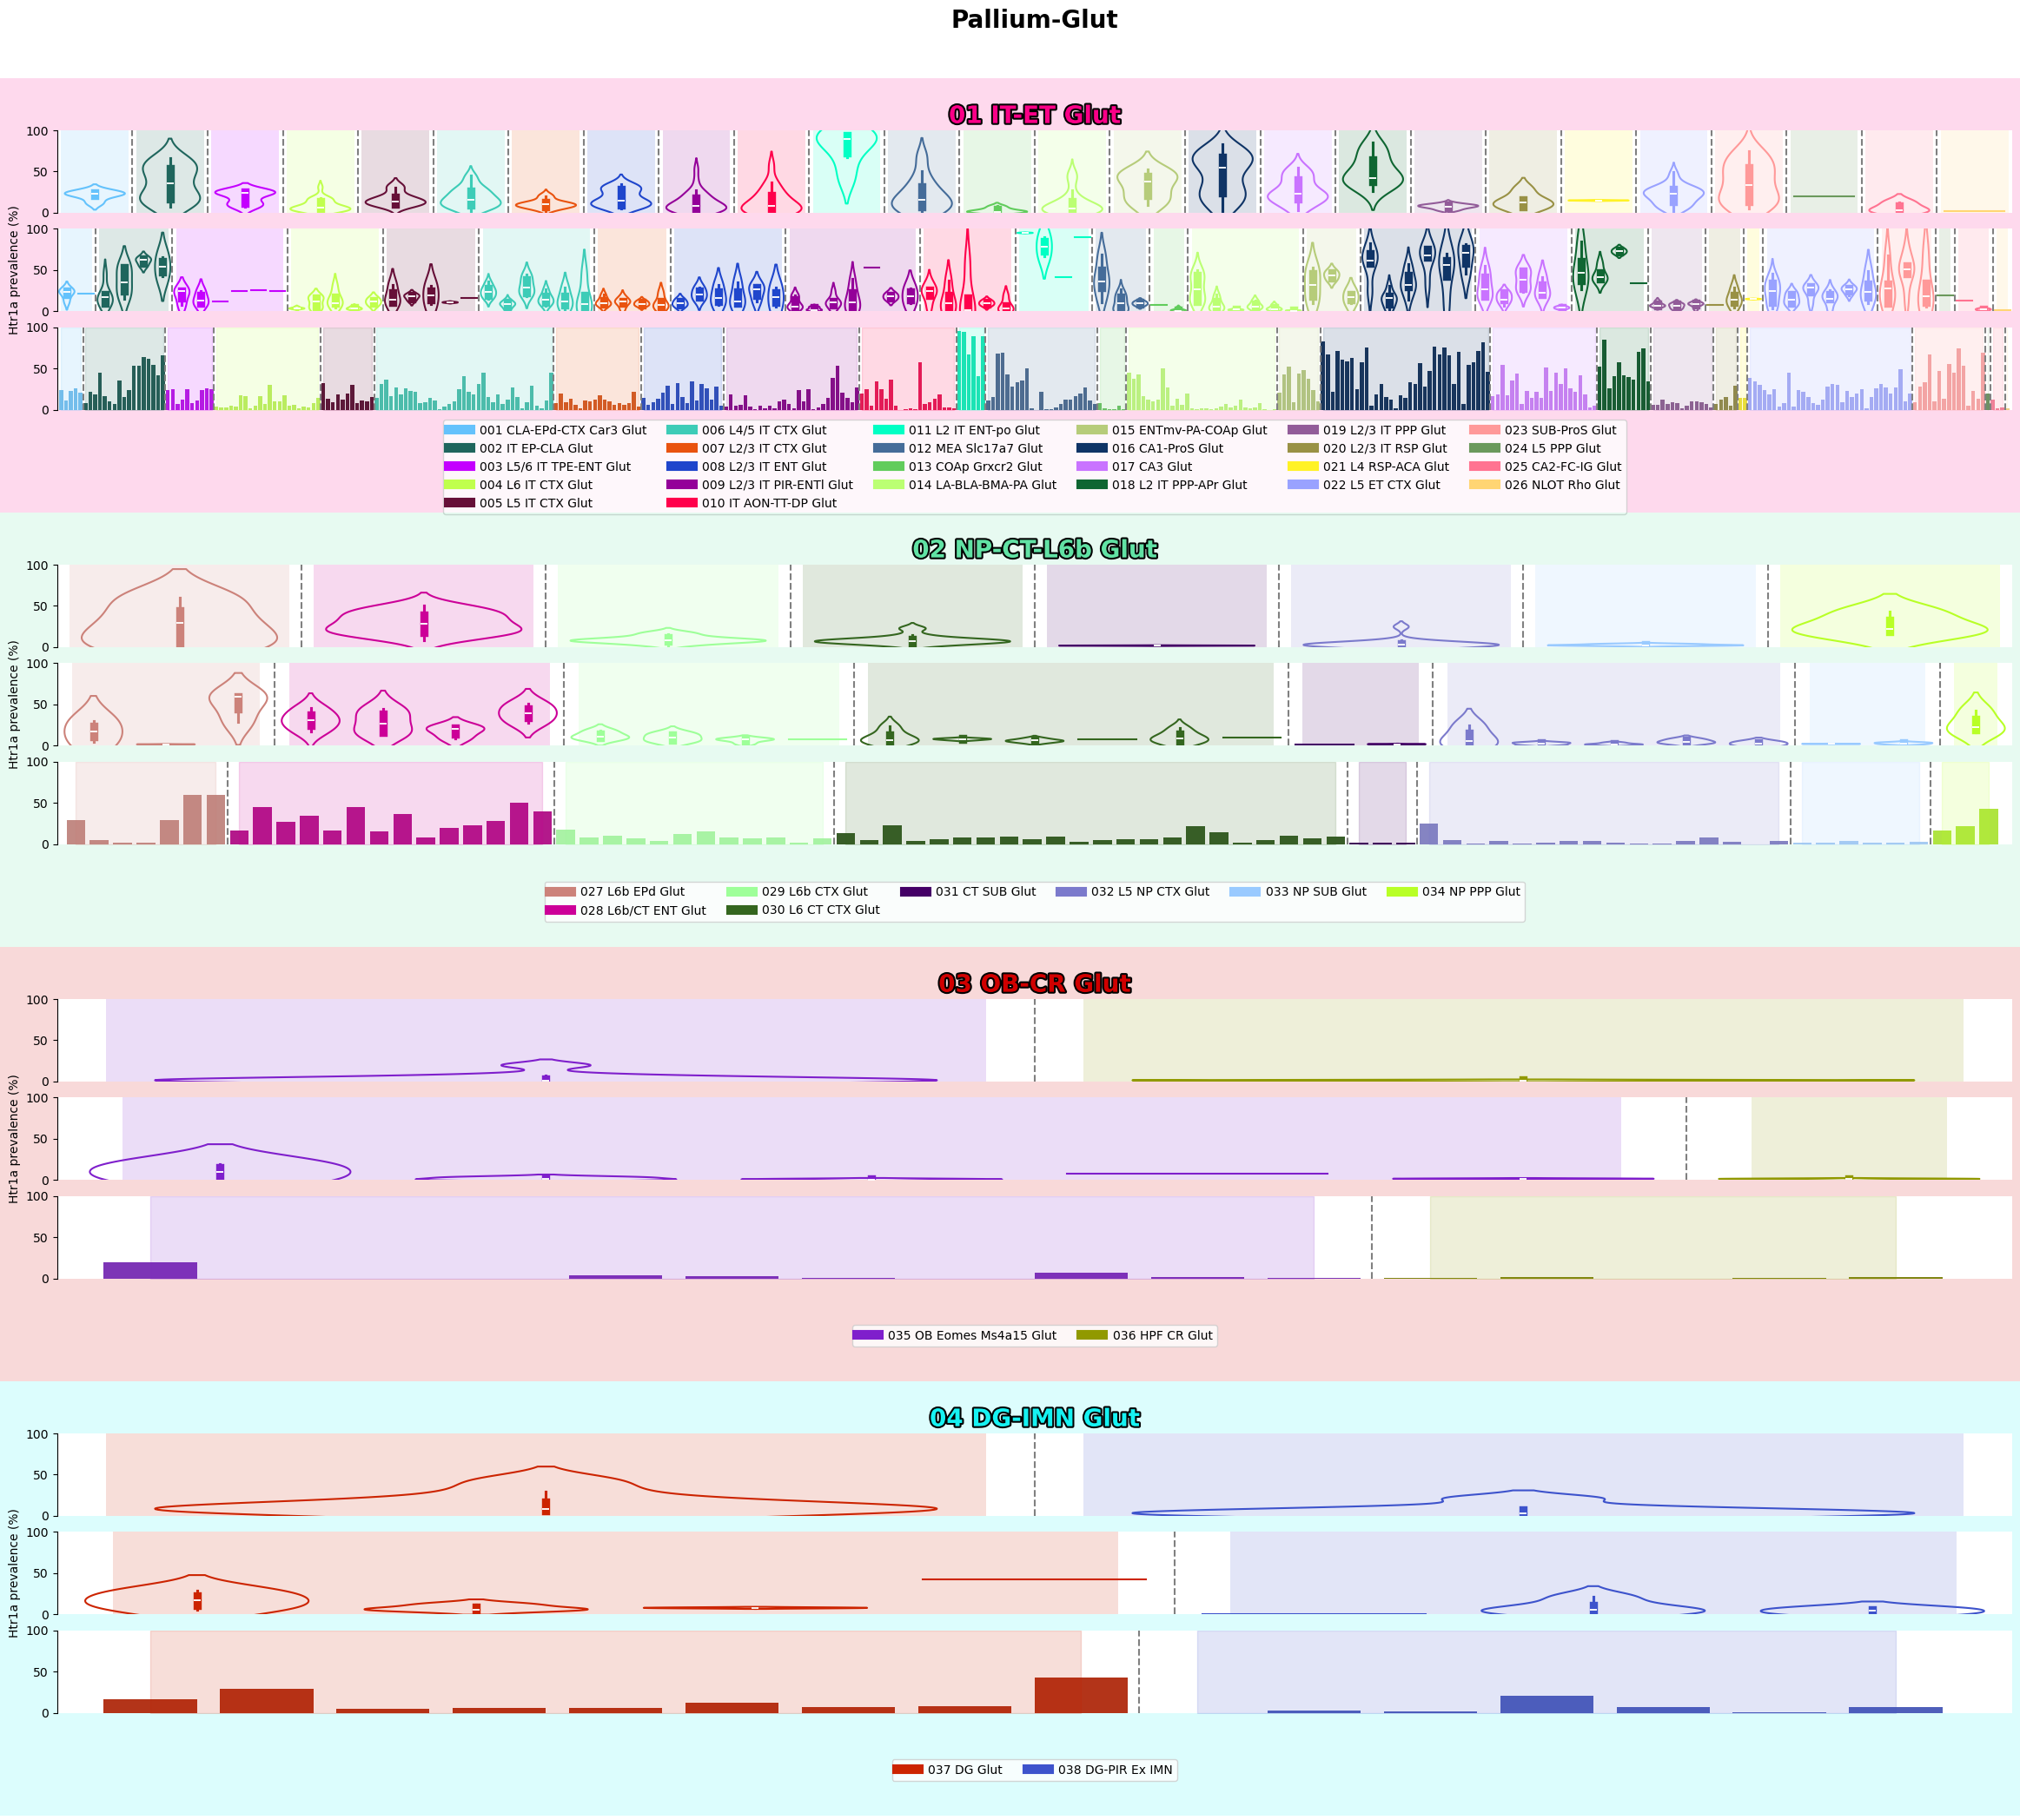

In [86]:
dashboard_cluster_centric = pn.Column(
                pn.Row(group_selector, gene_selector, save_button),
                pn.pane.Matplotlib(interactive_plot, sizing_mode = 'stretch_width')
            )

## cell centric

In [108]:
def update_subclass_selector(event):
    selected_classes = event.new
    if "None" in selected_classes or not selected_classes:
        all_subclasses = sorted(joined_sub["subclass"].unique().tolist())
    else:
        all_subclasses = sorted(joined_sub[joined_sub["class"].isin(selected_classes)]["subclass"].unique().tolist())
    subclass_selector.options = ["None"] + all_subclasses
    subclass_selector.value = ["None"]

class_selector = pn.widgets.MultiSelect(name='Class selector', options=["None"] + sorted(joined_sub["class"].unique().tolist()), value=[joined_sub["class"].unique()[0]])
subclass_selector = pn.widgets.MultiSelect(name='Subclass selector', options=["None"] + sorted(joined_sub["subclass"].unique().tolist()), value=["None"])
groupby_selector = pn.widgets.Select(name='Group by', options=["class", "subclass", "supertype", "cluster"], value="class")
sortby_selector = pn.widgets.Select(name='Sort by', options=["class"] + list(selected_genes_cl), value="class")

class_selector.param.watch(update_subclass_selector, 'value')

@pn.depends(class_selector, subclass_selector, groupby_selector, sortby_selector)
def heatmap_cell_centric(class_, subclass, groupby, sortby):

    if class_ != ["None"] or subclass != ["None"]:
        
        filtered_data = joined_sub
        if "None" not in class_:
            filtered_data = filtered_data[filtered_data["class"].isin(class_)]
        if "None" not in subclass:
            filtered_data = filtered_data[filtered_data["subclass"].isin(subclass)]

        if sortby == "class":
            sortby = groupby
            ascending = False
        else:
            ascending = True


        heatmap_data = filtered_data.groupby(groupby)[selected_genes_cl].apply(percentage_above_threshold).sort_values(sortby, ascending=ascending).reset_index()

        # Convert to a format suitable for Holoviews HeatMap
        heatmap_data = pd.melt(heatmap_data, id_vars=[groupby], value_vars=selected_genes_cl)
        # Calculate the height of the heatmap
        unique_groups = heatmap_data[groupby].nunique()
        fig_height = max(200, unique_groups * 20)  # 20 pixels per group, adjust as needed

        # Create HeatMap
        heatmap = hv.HeatMap(heatmap_data, kdims=['variable', groupby], vdims=['value']).opts(
            cmap='RdYlBu_r', width=600, height=fig_height, tools=['hover'], active_tools=[], colorbar=True, 
            xlabel='Gene', ylabel=groupby, clim=(0, 100), clabel='Prevalence (%)'
        )

        # Customizing the plot
        # Note: Custom color for each gene and classification like in the original function might require more complex handling
        return heatmap

    else:
        # Return an empty plot with a message if no data
        return hv.Text(0.5, 0.5, 'No data to display').opts(xaxis=None, yaxis=None)


dashboard_cell_centric = pn.Column(pn.Row(class_selector,subclass_selector,groupby_selector, sortby_selector),
heatmap_cell_centric)

### Create data for heatmap_region_centric

In [109]:

# data_merfish = pd.concat(sub_merfish_data).sort_values(by='brain_section_label')
# data_merfish = data_merfish[data_merfish['parcellation_category'] == "grey"]

# data_merfish["parcellation_division"] = pd.Categorical(data_merfish["parcellation_division"], categories=order_division, ordered=True)

Create data based on clustering RNA-seq. if gene is not used in the clustering it will have very few enriched clusters and most cells will be ignored. We are calculating he proportion of cells belonging to enriched clusters over total number neurons.

In [110]:
# out = []
# for gene in tqdm(selected_genes):
#     gene_prev_clu = joined.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)

#     _ = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))]
#          .groupby(['parcellation_division', 'parcellation_structure'],observed=True).size()/data_merfish.groupby(['parcellation_division', 'parcellation_structure'], observed=True).size())*100

#     # Here we create the proportion for the whole brain
#     division_proportions = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))]
#          .groupby(['parcellation_division'],observed=True).size()/data_merfish.groupby(['parcellation_division'], observed=True).size())*100

#     division_proportions = division_proportions.reset_index()

#     division_proportions['parcellation_structure'] = division_proportions['parcellation_division']
#     division_proportions['parcellation_division'] = "Whole brain"
#     division_proportions = division_proportions.set_index(['parcellation_division', 'parcellation_structure']).squeeze()

#     _ = pd.concat([_, division_proportions])

#     _.name=gene
#     out.append(_)

# dict_expr_by_reg = {}
# dict_expr_by_reg["Tot"] = pd.concat(out, axis=1).fillna(0)

# for neurotransmitter in tqdm(joined["neurotransmitter"].unique()):
#     joined_by_neurotransmitter = joined[joined["neurotransmitter"]==neurotransmitter]
#     temp=[]
#     for gene in selected_genes:
#         gene_prev_clu = joined_by_neurotransmitter.groupby("cluster")[gene].apply(percentage_above_threshold).sort_values(ascending=False)
#         sel_clu = joined_by_neurotransmitter["cluster"]
    
#         _ = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size()/data_merfish[(data_merfish["cluster"].isin(sel_clu))].groupby(['parcellation_division', 'parcellation_structure'],observed=True).size())*100

#         division_proportions = (data_merfish[(data_merfish["cluster"].isin(gene_prev_clu[gene_prev_clu>threshold_enriched_clusters].index))]
#          .groupby(['parcellation_division'],observed=True).size()/data_merfish.groupby(['parcellation_division'], observed=True).size())*100

#         division_proportions = division_proportions.reset_index()
    
#         division_proportions['parcellation_structure'] = division_proportions['parcellation_division']
#         division_proportions['parcellation_division'] = "Whole brain"
#         division_proportions = division_proportions.set_index(['parcellation_division', 'parcellation_structure']).squeeze()
    
#         _ = pd.concat([_, division_proportions])
        
        
#         _.name=gene
#         temp.append(_)
    
#     dict_expr_by_reg[neurotransmitter] =  pd.concat(temp, axis=1).fillna(0)

In [111]:
# with open(f"{root_visualizer_data}/expr_by_region.pkl", 'wb') as pickle_file:
#     pickle.dump(dict_expr_by_reg, pickle_file)

Create data based only on MERFISH dataset.

In [112]:
# out = []
# for gene in tqdm(selected_genes):
#     _ = data_merfish.groupby(['parcellation_division', 'parcellation_structure'],observed=True)[gene].apply(percentage_above_threshold_MER).sort_values(ascending=False)

#     # Here we create the proportion for the whole brain
#     division_proportions =  data_merfish.groupby(['parcellation_division'],observed=True)[gene].apply(percentage_above_threshold_MER).sort_values(ascending=False)


#     division_proportions = division_proportions.reset_index()
    
#     division_proportions['parcellation_structure'] = division_proportions['parcellation_division']
#     division_proportions['parcellation_division'] = "Whole brain"
#     division_proportions = division_proportions.set_index(['parcellation_division', 'parcellation_structure']).squeeze()
    
#     _ = pd.concat([_, division_proportions])
    
#     _.name=gene
#     out.append(_)

# dict_expr_by_reg = {}
# dict_expr_by_reg["Tot"] = pd.concat(out, axis=1).fillna(0)

# for neurotransmitter in tqdm(data_merfish["neurotransmitter"].unique()):
#     data_merfish_per_neurotransmitter = data_merfish[data_merfish["neurotransmitter"]==neurotransmitter]
#     temp=[]
#     for gene in selected_genes:
#         _ = data_merfish_per_neurotransmitter.groupby(['parcellation_division', 'parcellation_structure'],observed=True)[gene].apply(percentage_above_threshold_MER).sort_values(ascending=False)

#         # Here we create the proportion for the whole brain
#         division_proportions =  data_merfish_per_neurotransmitter.groupby(['parcellation_division'],observed=True)[gene].apply(percentage_above_threshold_MER).sort_values(ascending=False)
    
    
#         division_proportions = division_proportions.reset_index()
        
#         division_proportions['parcellation_structure'] = division_proportions['parcellation_division']
#         division_proportions['parcellation_division'] = "Whole brain"
#         division_proportions = division_proportions.set_index(['parcellation_division', 'parcellation_structure']).squeeze()
        
#         _ = pd.concat([_, division_proportions])
#         _.name=gene
#         temp.append(_)
        
#     dict_expr_by_reg[neurotransmitter] =  pd.concat(temp, axis=1).fillna(0)

In [113]:
# with open(f"{root_visualizer_data}/expr_by_region_only_MERFISH.pkl", 'wb') as pickle_file:
#     pickle.dump(dict_expr_by_reg, pickle_file)

#### Load data for heatmap_region_centric

In [114]:
with open(f'{root_visualizer_data}/expr_by_region.pkl', 'rb') as pickle_file:
    dict_expr_by_reg = pickle.load(pickle_file)

In [115]:
with open(f'{root_visualizer_data}/expr_by_region_only_MERFISH.pkl', 'rb') as pickle_file:
    dict_expr_by_reg_only_MERFISH = pickle.load(pickle_file)

In [116]:
division_selector = pn.widgets.MultiSelect(name='Division selector', options=["Whole brain"] + order_division , value=[( ["Whole brain"] + order_division )[0]])
type_selector = pn.widgets.MultiSelect(name='Neurotransmitter selector', options=["Tot", 'Glut', 'GABA', 'Glut-GABA', 'Dopa', '', 'GABA-Glyc', 'Chol',
       'Hist', 'Sero', 'Nora'], value=["Tot"])

with open('/alzheimer/Roberto/Github/Transcriptomics-5-HT-huggingface/Data/expr_by_region.pkl', 'rb') as pickle_file:
    dict_expr_by_reg = pickle.load(pickle_file)

with open('/alzheimer/Roberto/Github/Transcriptomics-5-HT-huggingface/Data/expr_by_region_only_MERFISH.pkl', 'rb') as pickle_file:
    dict_expr_by_reg_only_MERFISH = pickle.load(pickle_file)

division_selector = pn.widgets.MultiSelect(name='Division selector', options=["Whole brain"] + order_division,
                                           value=[(["Whole brain"] + order_division)[0]])
type_selector = pn.widgets.MultiSelect(name='Neurotransmitter selector',
                                       options=["Tot", 'Glut', 'GABA', 'Glut-GABA', 'Dopa', '', 'GABA-Glyc', 'Chol',
                                                'Hist', 'Sero', 'Nora'], value=["Tot"])
data_source_selector = pn.widgets.Select(name='Data Source Selector', options=['scRNAseq + MERFISH', 'MERFISH only'],
                                         value='scRNAseq + MERFISH')
sortby_selector = pn.widgets.Select(name='Sort by', options=["region"] + list(selected_genes), value="region")


@pn.depends(division_selector, type_selector, data_source_selector, sortby_selector)
def heatmap_region_centric(division, type_selector, data_source, sortby):
    if data_source == 'scRNAseq + MERFISH':
        data_dict = dict_expr_by_reg
    elif data_source == "MERFISH only":
        data_dict = dict_expr_by_reg_only_MERFISH

    if sortby == "region":
        heatmap_data = data_dict[type_selector[0]].loc[division[0]].sort_values("parcellation_structure")
    else:
        heatmap_data = data_dict[type_selector[0]].loc[division[0]].sort_values(sortby, ascending=False)

    fig_height = max(200, heatmap_data.shape[0] * 20)
    # Create HeatMap
    heatmap = heatmap_data.hvplot.heatmap().opts(
        cmap='RdYlBu_r', width=600, height=fig_height, tools=['hover'], active_tools=[], colorbar=True,
        xlabel='Gene', ylabel='Structure', invert_yaxis=True, clabel='Prevalence (%)'
    )
    return heatmap


dashboard_region_centric_dashboard = pn.Column(
    pn.Row(data_source_selector, division_selector, type_selector, sortby_selector),
    heatmap_region_centric
)



In [117]:
dashboard = pn.template.BootstrapTemplate(
    header_background="#F9B9B7",
    logo="https://upload.wikimedia.org/wikipedia/commons/5/51/Logo_Charite.svg",
    title="5-HT Transcriptomics",
    main=pn.Column(
        pn.Tabs(
            ("Spatial MERFISH (MERFISH)", dashboard_spatial), 
            ("Gene by class/subclass/supertype/cluster (RNA-seq)", dashboard_cluster_centric),
            ("Overview genes by class/subclass (RNA-seq)", dashboard_cell_centric),
            ("Overview genes by brain structure (MERFISH)",dashboard_region_centric_dashboard),
            dynamic=True
        )
    )
)

In [118]:
dashboard.show()

Launching server at http://localhost:41903
